<a href="https://colab.research.google.com/github/arkod123/dataByte/blob/master/TweetDataInsights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this notebook will explore the data and vizualisation*

In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import plotly.express as px
import re
import string
from bs4 import BeautifulSoup
import pickle as pk
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
import matplotlib.pyplot as plt
# set default parameters
nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("/content/drive/My Drive/Tweet_sentiment_analysis/sentiment_tweet_train.csv")
print("# of rows {} and # of columns {}".format(df.shape[0], df.shape[1]))
print("Headers: {}".format(list(df.columns)))

# of rows 7920 and # of columns 3
Headers: ['id', 'label', 'tweet']


In [3]:
count_df = df.groupby('label').count().reset_index()
count_df['label'] = np.where(count_df['label'] == 0, "positive", "negative")
count_df.rename(columns={"tweet" : "#_of_tweet"}, inplace=True)
px.bar(count_df, x="label", y="#_of_tweet", color="label", title="positive Vs. negative counts")

In [45]:
testString = "Just received the #Samsung Note 2, many thanks to @COTTDS #phone http://instagr.am/p/RIQsBaBG_O/ ASAS https://www.instagram.com/p/BcsKTNNn51c/  asad 3333"
pattern = re.compile("[0-9]")
testString = testString.translate(str.maketrans('', '', string.punctuation))
print(testString)
print(re.findall(pattern, testString))
print(re.sub(pattern, '', testString))

Just received the Samsung Note 2 many thanks to COTTDS phone httpinstagrampRIQsBaBGO ASAS httpswwwinstagramcompBcsKTNNn51c  asad 3333
['2', '5', '1', '3', '3', '3', '3']
Just received the Samsung Note  many thanks to COTTDS phone httpinstagrampRIQsBaBGO ASAS httpswwwinstagramcompBcsKTNNnc  asad 


In [3]:
# Removing HTML tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
# Removing URL
def remove_url(text):
  pattern=re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
  text = re.sub(pattern, '', text)
  return text
# Removing Special Characters
def remove_special_char_digit(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  pattern = re.compile("[0-9]")
  text = re.sub(pattern, '', text)
  return text
# Removing accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
# Lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
# Removing Stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
# read contraction map file
def read_contraction_map_file():
  with open("/content/drive/My Drive/Tweet_sentiment_analysis/contraction_map.pk", 'rb') as fo:
    CONTRACTION_MAP = pk.load(fo)
  return CONTRACTION_MAP
# Expanding contractions
def expand_contractions(text, contraction_mapping=read_contraction_map_file()):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
# combined preprocessed
def get_pre_processed(text):
  step1 = strip_html_tags(text)
  step2 = remove_url(step1)
  step3 = remove_special_char_digit(step2)
  step4 = remove_accented_chars(step3)
  step5 = lemmatize_text(step4)
  step6 = remove_stopwords(step5)
  step7 = expand_contractions(step6)
  return (step7)
# run all
df["tweet"] = df["tweet"].apply(get_pre_processed)
#df.to_csv('/content/drive/My Drive/Tweet_sentiment_analysis/sentiment_tweet_train_preProcessed.csv')
  

In [18]:
df["tweet"]
pos_comment = df[df['label'] == 0]
neg_comment = df[df['label'] == 1]

In [5]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [16]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(' '.join(pos_comment['tweet']))

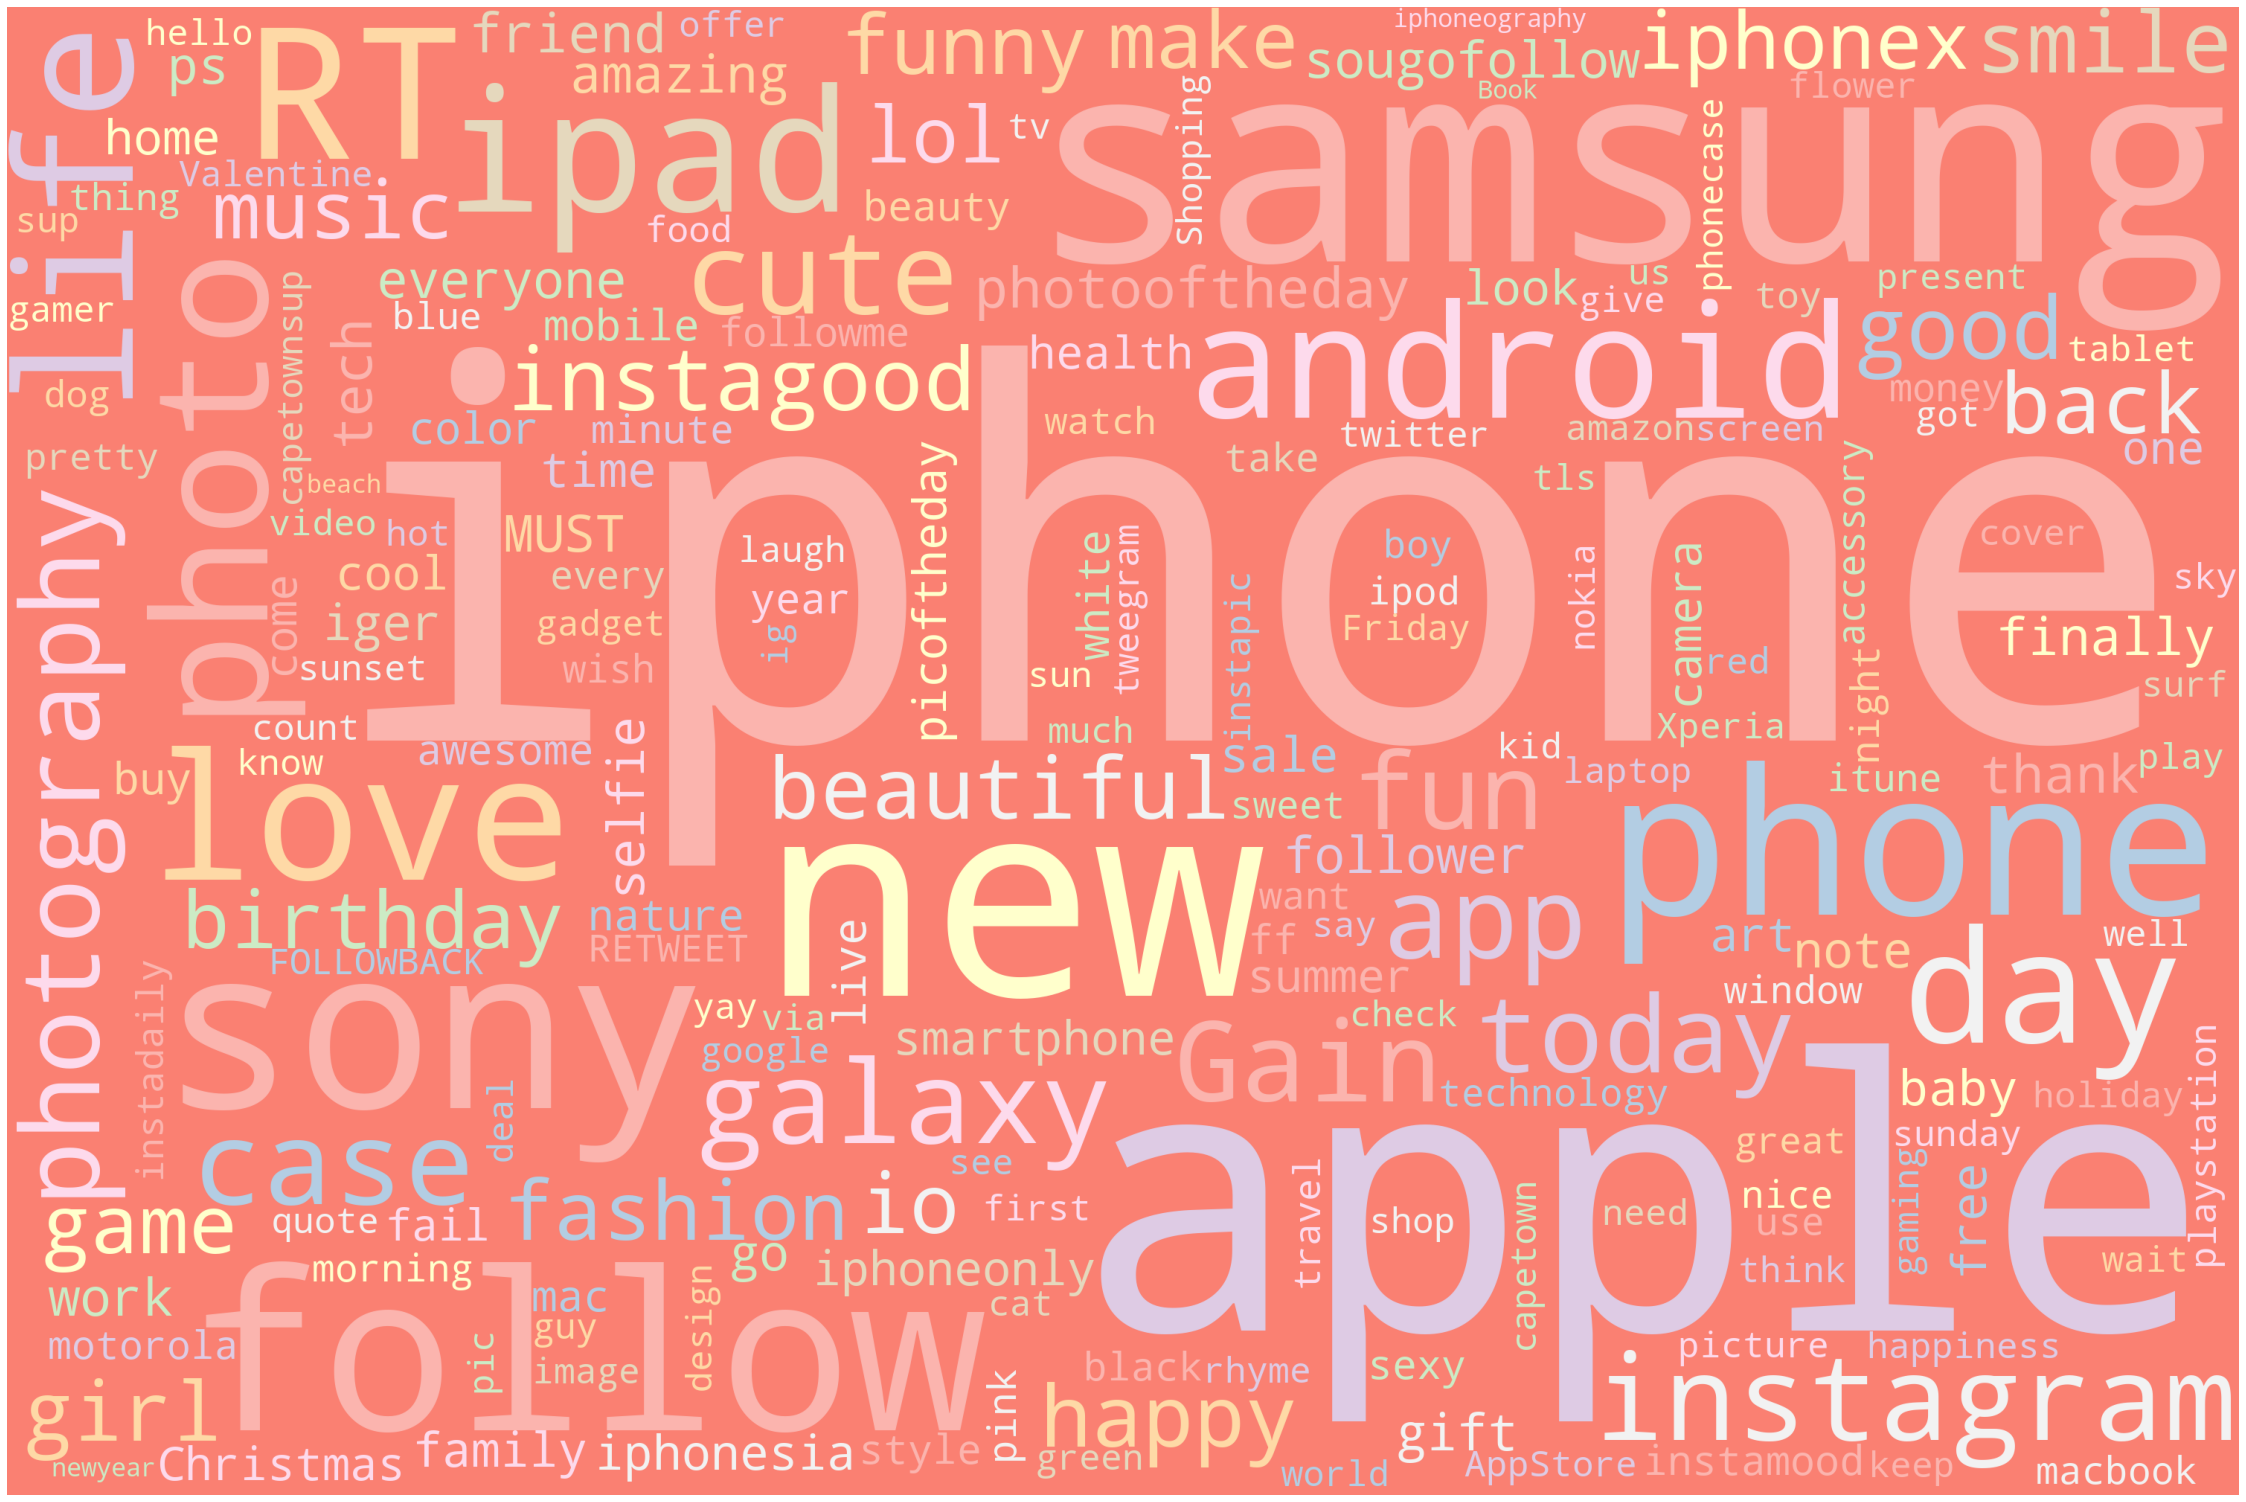

In [17]:
plot_cloud(wordcloud)

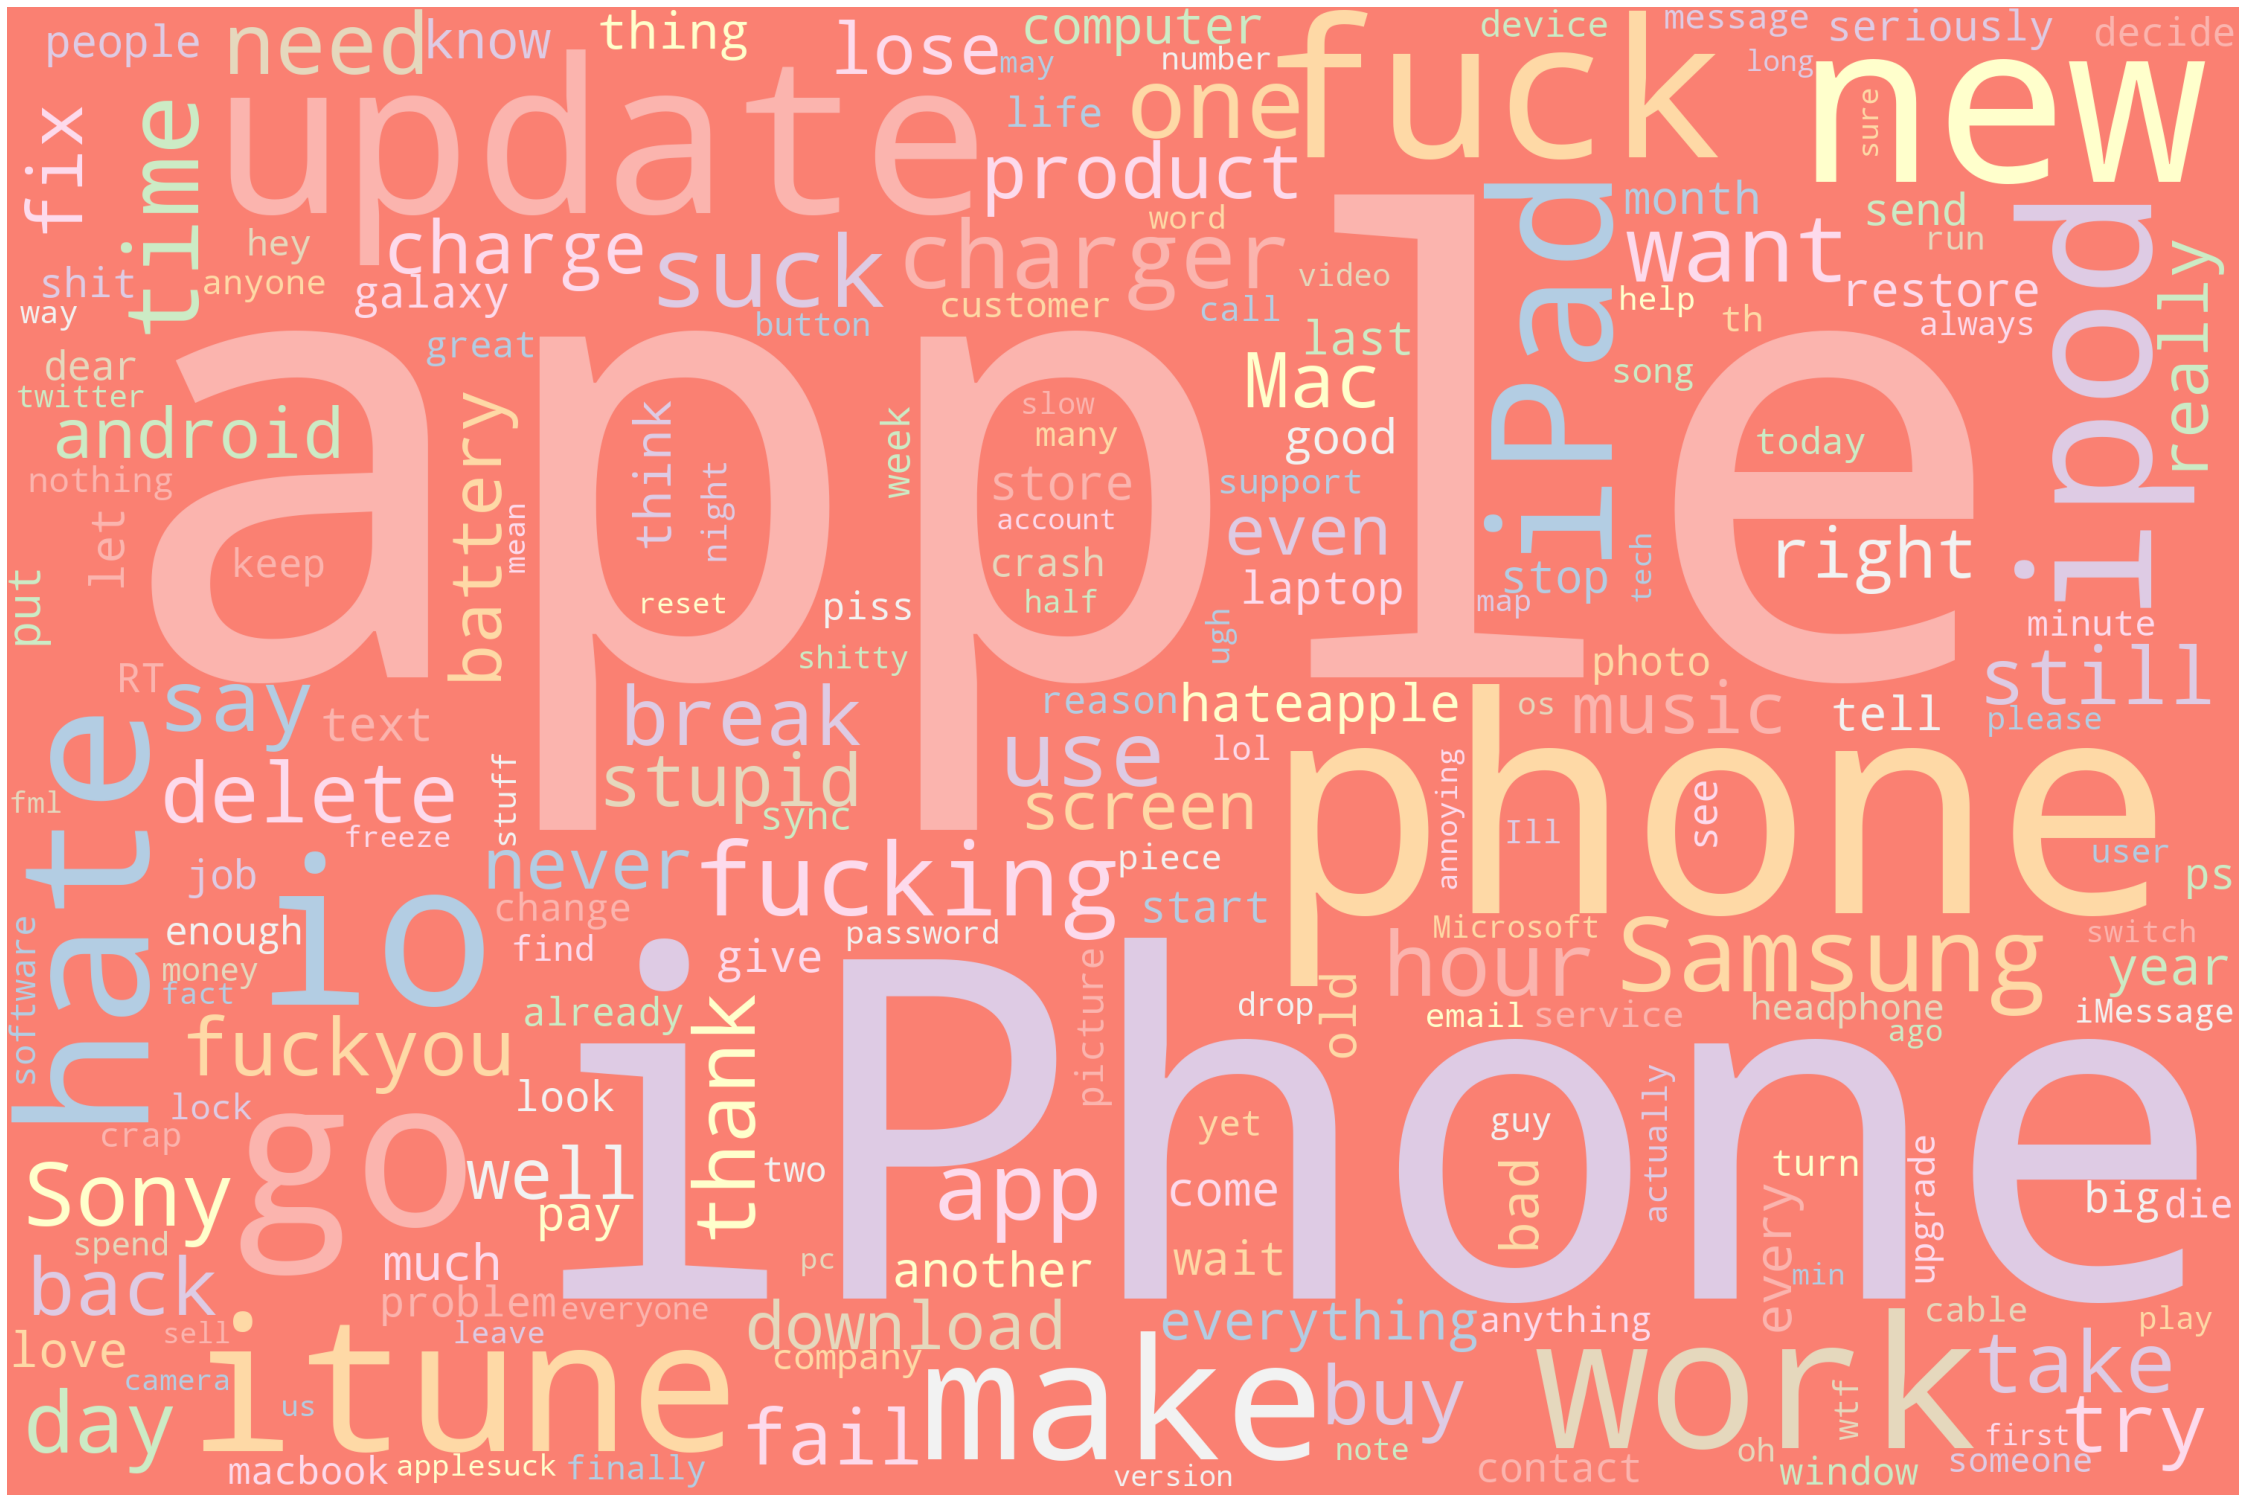

In [19]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(' '.join(neg_comment['tweet']))
plot_cloud(wordcloud)